# Iris Classification

## Importing libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split

tf.__version__
#os.listdir()

'2.3.0'

## Data Preprocessing

In [2]:
COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
LABELS = {}
features = COLUMN_NAMES[:-1]

In [3]:
df = pd.read_csv('iris_training.csv', names = COLUMN_NAMES, header = 0)
df.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


In [4]:
for i, label in enumerate(set(df['Species'])):
    LABELS[label] = i
print(LABELS)

y = df.pop('Species')

{'Iris-versicolor': 0, 'Iris-virginica': 1, 'Iris-setosa': 2}


In [5]:
def str2label(s):
    return LABELS[s]

y = list(map(lambda s: str2label(s), y))
print(y)

df[:2]

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


,SepalLength,SepalWidth,PetalLength,PetalWidth
0,4.9,3.0,1.4,0.2
1,4.7,3.2,1.3,0.2


In [6]:
desc = df.describe()
desc

,SepalLength,SepalWidth,PetalLength,PetalWidth
count,149.000000,149.000000,149.000000,149.000000
mean,5.848322,3.051007,3.774497,1.205369
std,0.828594,0.433499,1.759651,0.761292
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.400000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
MEAN = np.array(desc.T['mean'])
STD = np.array(desc.T['std'])

def normalize(df, MEAN, STD):
    for i, feature in enumerate(features):
        feature = str(feature)
        df[feature] = (df[feature] - MEAN[i]) / STD[i]
    return df
        
df = normalize(df, MEAN, STD)
df.describe()

,SepalLength,SepalWidth,PetalLength,PetalWidth
count,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02
mean,-2.019684e-15,-1.929478e-15,-1.394857e-15,-1.182499e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.868614e+00,-2.424474e+00,-1.576731e+00,-1.451965e+00
25%,-9.031228e-01,-5.790251e-01,-1.235754e+00,-1.189253e+00
50%,-5.831824e-02,-1.176628e-01,3.554701e-01,1.243030e-01
75%,6.657999e-01,5.743805e-01,7.532762e-01,7.810812e-01
max,2.476095e+00,3.111873e+00,1.776206e+00,1.700571e+00


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

print('Training: {}, Validation: {}, Test: {}'.format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

Training: 119, Validation: 15, Test: 15


In [9]:
N_TRAIN = X_train.shape[0]
BATCH_SIZE = 32
STEPS = N_TRAIN // BATCH_SIZE
print(STEPS)

3


In [10]:
def dataframe_to_dataset(df, y, shuffle = True, repeat = False, batch_size = BATCH_SIZE):
    df = df.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(df), y))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(df)) 
    ds = ds.batch(batch_size)
    if repeat:
        ds = ds.repeat()
    
    return ds

In [11]:
train_ds = dataframe_to_dataset(X_train, y_train, repeat = True)
val_ds = dataframe_to_dataset(X_val, y_val)
test_ds = dataframe_to_dataset(X_test, y_test)

print('train_ds.cardinality:', train_ds.cardinality().numpy())
print('val_ds.cardinality:', val_ds.cardinality().numpy())
print('test_ds.cardinality:', test_ds.cardinality().numpy())

# Viewing the a batch of training example
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of SepalLength:', feature_batch['SepalLength'])
    print('A batch of targets:', label_batch)

train_ds.cardinality: -1
val_ds.cardinality: 1
test_ds.cardinality: 1
Every feature: ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
A batch of SepalLength: tf.Tensor(
[-1.62724091  1.63129079  0.06236812 -0.42037732 -1.50655455  1.02785899
  2.23472258 -1.02380911 -1.74792727 -1.26518183 -0.54106368  0.78648627
  0.78648627  0.54511356  0.54511356 -0.7824364   0.66579991 -0.7824364
  1.38991807 -1.26518183  0.66579991  0.78648627  1.75197715  0.4244272
  1.02785899  0.66579991 -0.05831824 -0.1790046  -1.26518183 -0.29969096
 -0.1790046  -1.74792727], shape=(32,), dtype=float64)
A batch of targets: tf.Tensor([2 1 1 0 2 0 1 2 2 2 2 1 1 1 1 2 0 2 0 2 1 1 1 1 0 0 1 0 2 1 1 2], shape=(32,), dtype=int32)


### Visualizing Data

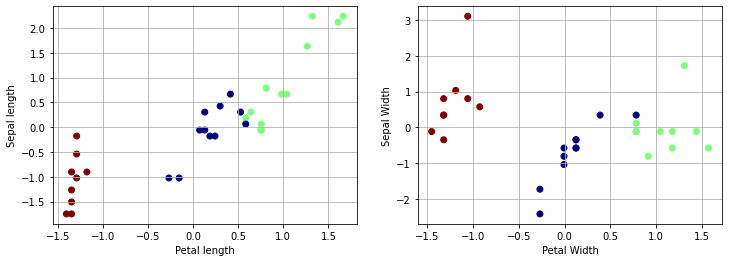

In [12]:
features, labels = next(iter(train_ds))

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.scatter(features['PetalLength'],
            features['SepalLength'],
            c=labels,
            cmap='jet')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.grid()

plt.subplot(1,2,2)
plt.scatter(features['PetalWidth'],
           features['SepalWidth'],
           c = labels,
           cmap = 'jet')
plt.xlabel("Petal Width")
plt.ylabel("Sepal Width")
plt.grid()

plt.show()

In [13]:
def pack_features_vector(features, labels):
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

train_ds = train_ds.map(pack_features_vector)
val_ds = val_ds.map(pack_features_vector)
test_ds = test_ds.map(pack_features_vector)

### Model Building

In [14]:
model = keras.models.Sequential([
    keras.layers.Dense(32, activation = 'relu', input_shape = (4,), kernel_regularizer = keras.regularizers.l2(0.0001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.0001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(8, activation = 'relu'),
    keras.layers.Dense(3)
])

In [15]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), \
              optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 1,507
Trainable params: 1,507
Non-trainable params: 0
______________________________________________________

## Training

In [16]:
epochs = 150

history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch = STEPS,
    epochs = epochs,
    verbose = 2
)

Epoch 1/150
3/3 - 0s - loss: 1.1131 - accuracy: 0.2917 - val_loss: 1.1057 - val_accuracy: 0.1333
Epoch 2/150
3/3 - 0s - loss: 1.0896 - accuracy: 0.3448 - val_loss: 1.0988 - val_accuracy: 0.1333
Epoch 3/150
3/3 - 0s - loss: 1.0835 - accuracy: 0.4138 - val_loss: 1.0913 - val_accuracy: 0.1333
Epoch 4/150
3/3 - 0s - loss: 1.0552 - accuracy: 0.4713 - val_loss: 1.0696 - val_accuracy: 0.2000
Epoch 5/150
3/3 - 0s - loss: 1.0419 - accuracy: 0.5521 - val_loss: 1.0352 - val_accuracy: 0.6667
Epoch 6/150
3/3 - 0s - loss: 1.0349 - accuracy: 0.5747 - val_loss: 1.0003 - val_accuracy: 0.7333
Epoch 7/150
3/3 - 0s - loss: 0.9979 - accuracy: 0.6897 - val_loss: 0.9588 - val_accuracy: 0.7333
Epoch 8/150
3/3 - 0s - loss: 0.9730 - accuracy: 0.6552 - val_loss: 0.9166 - val_accuracy: 0.7333
Epoch 9/150
3/3 - 0s - loss: 0.9452 - accuracy: 0.7083 - val_loss: 0.8736 - val_accuracy: 0.7333
Epoch 10/150
3/3 - 0s - loss: 0.9174 - accuracy: 0.7011 - val_loss: 0.8321 - val_accuracy: 0.7333
Epoch 11/150
3/3 - 0s - loss:

Epoch 85/150
3/3 - 0s - loss: 0.1875 - accuracy: 0.9583 - val_loss: 0.0742 - val_accuracy: 1.0000
Epoch 86/150
3/3 - 0s - loss: 0.2023 - accuracy: 0.9310 - val_loss: 0.0710 - val_accuracy: 1.0000
Epoch 87/150
3/3 - 0s - loss: 0.1429 - accuracy: 0.9655 - val_loss: 0.0681 - val_accuracy: 1.0000
Epoch 88/150
3/3 - 0s - loss: 0.2056 - accuracy: 0.9310 - val_loss: 0.0656 - val_accuracy: 1.0000
Epoch 89/150
3/3 - 0s - loss: 0.1813 - accuracy: 0.9479 - val_loss: 0.0632 - val_accuracy: 1.0000
Epoch 90/150
3/3 - 0s - loss: 0.1469 - accuracy: 0.9425 - val_loss: 0.0609 - val_accuracy: 1.0000
Epoch 91/150
3/3 - 0s - loss: 0.1549 - accuracy: 0.9540 - val_loss: 0.0584 - val_accuracy: 1.0000
Epoch 92/150
3/3 - 0s - loss: 0.1647 - accuracy: 0.9425 - val_loss: 0.0560 - val_accuracy: 1.0000
Epoch 93/150
3/3 - 0s - loss: 0.1608 - accuracy: 0.9688 - val_loss: 0.0543 - val_accuracy: 1.0000
Epoch 94/150
3/3 - 0s - loss: 0.1388 - accuracy: 0.9540 - val_loss: 0.0533 - val_accuracy: 1.0000
Epoch 95/150
3/3 - 0

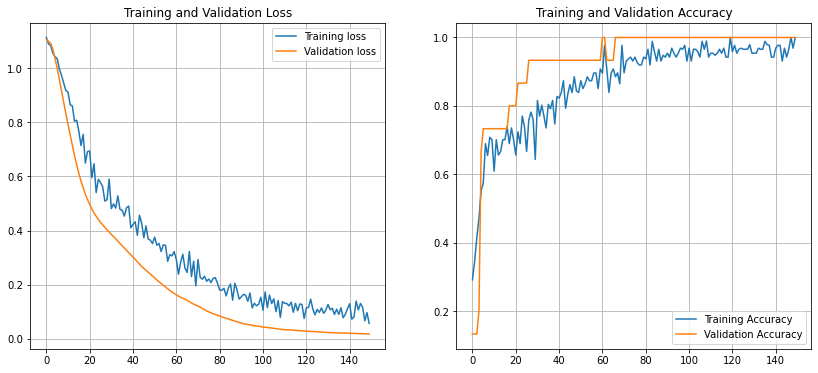

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(epochs_range, loss, label = 'Training loss')
plt.plot(epochs_range, val_loss, label = 'Validation loss')
plt.legend()
plt.grid()
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Training and Validation Accuracy')

plt.show()

## Evaluate and Predict

In [18]:
model.evaluate(test_ds)

1/1 [==============================] - 0s 3ms/step - loss: 0.0324 - accuracy: 1.0000


[0.032375846058130264, 1.0]

In [19]:
predict_model = keras.Sequential([
    model,
    keras.layers.Softmax()
])

In [20]:
def predict(prediction):
    for score in prediction:
        class_idx = tf.argmax(score).numpy()
        for key, value in LABELS.items():
            if value == class_idx:
                class_name = key
        print('Prediction: Class: {:15s}, Probability: {:.2f}%'.format(class_name, max(score * 100)))
        
        
prediction = predict_model.predict(test_ds)
predict(prediction)

Prediction: Class: Iris-versicolor, Probability: 98.90%
Prediction: Class: Iris-versicolor, Probability: 85.83%
Prediction: Class: Iris-setosa    , Probability: 99.99%
Prediction: Class: Iris-virginica , Probability: 95.50%
Prediction: Class: Iris-virginica , Probability: 90.64%
Prediction: Class: Iris-setosa    , Probability: 100.00%
Prediction: Class: Iris-virginica , Probability: 97.10%
Prediction: Class: Iris-virginica , Probability: 99.46%
Prediction: Class: Iris-setosa    , Probability: 100.00%
Prediction: Class: Iris-setosa    , Probability: 99.99%
Prediction: Class: Iris-setosa    , Probability: 99.99%
Prediction: Class: Iris-virginica , Probability: 99.93%
Prediction: Class: Iris-versicolor, Probability: 99.73%
Prediction: Class: Iris-virginica , Probability: 99.73%
Prediction: Class: Iris-versicolor, Probability: 94.08%


In [21]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

p_ds = pd.DataFrame(predict_dataset.numpy())

def convert_to_ds(p_ds):
    p_desc = p_ds.describe()
    mean = np.array([p_desc.T['mean']])
    std = np.array([p_desc.T['std']])
    for col in range(p_ds.shape[-1]):
        p_ds[col] = (p_ds[col] - mean[0][col]) / std[0][col]
    return p_ds
    
    
p_ds = convert_to_ds(p_ds)
predict(predict_model.predict(p_ds))

Prediction: Class: Iris-setosa    , Probability: 99.99%
Prediction: Class: Iris-versicolor, Probability: 97.74%
Prediction: Class: Iris-virginica , Probability: 97.75%
